In [1]:
import numpy as np
import numpy.random as rnd

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#### Все места, где нужно дописать код отмечены TODO.

## Считывание и подготовка данных.

In [2]:
# Считываем данные: каждый класс лежит в своем csv файле. 
male = pd.read_csv('male.csv',header = None)[0]
female = pd.read_csv('female.csv',header = None)[0]

y = np.hstack((np.zeros(len(male)),np.ones(len(female))))
data = list(male)
data.extend(list(female))

In [3]:
# Для дальнейшей работы нам понадобится словарь символов + 
# мы не будем различать строчные и прописные буквы + 
# у нас все последовательности разной длины и нам нужно понимать, какова макимальная длина + 
# нам нужен отдельный символ под паддинг, чтобы уметь работать с последовательностями разной длины
MAX_LEN = 0
chars = set()
for i in xrange(len(data)):
    data[i] = data[i].lower()
    MAX_LEN = max(MAX_LEN,len(data[i]))
    chars = chars.union(set(data[i][:]))
    
chars = list(chars)
PAD_CHAR = '_PADDING_'
chars = [PAD_CHAR] + chars
char_to_id = { ch:id for id,ch in enumerate(chars) }
id_to_char = { id:ch for id,ch in enumerate(chars) }

VOCAB_SIZE = len(chars)

In [4]:
# Разделим выборку на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

In [5]:
def data2format(data, labels):
    """Функция преобразует выбоку данных в формат, подходящий для подачи в нейронную сеть.
    
    data - список строк (пример - X_train)
    labels - вектор меток для строк из data (пример - y_train)
    
    Дальше за N обозначается число строк в data
    
    Вернуть нужно словарь со следующими элементами:
    x - матрица размера [N, MAX_LEN], в которой каждая строка соответствует строке в data:
        вся строка кодируется с помощью char_to_id, недостающие элементы в конце коротких строк заполняются символом PAD_CHAR
    y - вектор длины N с метками
    
    """
    N = len(data)
    X = np.ones((N, MAX_LEN), dtype=np.int) * char_to_id[PAD_CHAR]

    for i, datum in enumerate(data):
        datum = datum.lower()
        for j in xrange(len(datum)):
            X[i, j] = char_to_id[datum[j]]
        
    return {
        'x': X,
        'y': np.array(labels, dtype=np.int)
    }

In [6]:
train_data = data2format(X_train,y_train)
test_data = data2format(X_test,y_test)
train_lengths = [len(x) for x in X_train]
test_lengths = [len(x) for x in X_test]

## Вспомогательные функции

In [7]:
# Необходимые константы
NUM_EPOCHS = 50
BATCH_SIZE = 100
SEQ_LEN = 20
LEARNING_RATE = 0.001
GRAD_CLIP = 100
USE_CUDA = True

In [8]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(train_err, train_acc, test_err, test_acc, network):
    return {'train_err':train_err, 
        'train_acc':train_acc, 
        'test_err':test_err, 
        'test_acc':test_acc, 
        'network':network
           } 

# устойчивая реализация кросс-энтропии
def BinaryCrossentropy(probs, labels):
    probs = probs[:, 0]
    probs = torch.clamp(probs, 1e-7, 1-1e-7)
    labels = labels.type(probs.data.type())
    return -(labels * torch.log(probs) + (1 - labels) * (torch.log(1 - probs))).mean()

## Нейронная сеть

В простейшем случае мы будем использовать сеть, которая считывает входную последовательность, и выдает результат только в самом конце.

In [9]:
# Для работы с последовательностями разной длины стоит использовать эти функции.
# Обратите внимание, что последователньости нужно отсортировать перед подачей в pack_padded_sequence.
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Net(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, MAX_LEN] 
    и применяет к нему следующие преобразования:
    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое. Из этого слоя нам нужно только выход в последний момент времени.
    3. Полносвязный слой для бинарной классификации с sigmoid в качестве нелинейности.
    
    * Обратите внимание на параметр batch_first у рекуррентного слоя.
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, mode=None, bidirect=False):
        super(Net, self).__init__()
        hidden_layers = 1
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, hidden_layers, batch_first=True, bidirectional=bidirect)
        self.decoder = nn.Linear(hidden_dim + bidirect * hidden_dim, 1)
        
        self.sigmoid = nn.Sigmoid()
        
        self.mode = mode

    def forward(self, names, lengths=None):
        encoded = self.encoder(names)
        output, hidden = self.rnn(encoded)

        if self.mode == 'avg':
            output = output.mean(1)
        elif self.mode == 'max':
            output = output.max(1)[0]
        else:
            output = output[:, -1]

        decoded = self.decoder(output)
        return self.sigmoid(decoded)

In [10]:
def make_batch_sampler(data, lengths=None):
#     targets_lengths = np.array([data['y'], lengths], dtype=np.int).T
    
    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.from_numpy(data['x']),
            torch.from_numpy(data['y'])
        ),
        batch_size=BATCH_SIZE,
        drop_last=True
    )

In [11]:
def train(train_data, test_data, emb_size, n_hidden, show=False, mode=None, bidirect=False):
    """Функция обучает нейросеть по данным train_data + контролирует процесс по качеству на test_data
    Следует обратить внимание на следующее:
    1. Сеть будем учить NUM_EPOCHS эпох, в каждой из столько батчей, сколько есть в train_data
    2. Генерировать батчи можно с помощью батчгенератора pytorch. Для этого пригодятся torch.utils.data.TensorDataset
        и torch.utils.data.DataLoader.
    3. Для того, чтобы следить за процессом обучения будем считать средний loss и 
        среднюю точность классификации на всех батчах трейна и теста и сохранять эти данные 
        в соответствующие массивы. 
    4. Перед тем, как делать шаг по градиенту, будем ограничивать градиент по норме значением GRAD_CLIP
    
    """
    print("Prepare data ...")
    
    train_batch_sampler = make_batch_sampler(train_data, train_lengths)
    test_batch_sampler = make_batch_sampler(test_data, test_lengths)

    train_err=np.zeros(NUM_EPOCHS)
    train_acc=np.zeros(NUM_EPOCHS)
    test_err=np.zeros(NUM_EPOCHS)
    test_acc=np.zeros(NUM_EPOCHS)

    print("Building network ...")
    # Строим сеть и переносим ее на cuda, если нужно
    net = Net(emb_size, n_hidden, VOCAB_SIZE, BATCH_SIZE, mode=mode, bidirect=bidirect)
    type_ = torch.LongTensor
    if USE_CUDA:
        net.cuda()
        type_ = torch.cuda.LongTensor
    print("The network has {} params".format(sum([x.data.numel() for x in net.parameters()])))
    
    # Задаем оптимизатор, рекомендуется использовать adam
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    
    def step(batch_sampler, optimize=True):
        error = 0
        accuracy = 0

        for batch_num, (X, y) in enumerate(batch_sampler):
            if optimize:
                optimizer.zero_grad()

            if USE_CUDA:
                y_true = Variable(y).cuda()
                y_pred = net(Variable(X).cuda())
            else:
                y_true = Variable(y)
                y_pred = net(Variable(X))

            loss = BinaryCrossentropy(y_pred, y_true)
            if optimize:
                loss.backward()
                nn.utils.clip_grad_norm(net.parameters(), GRAD_CLIP)
                optimizer.step()

            error += loss.data[0]

            
            y_lbls = (y_pred > 0.5).type(type_).view(y_pred.size()[0])
            acc = y_lbls.eq(y_true).type(type_)
            accuracy += acc.sum().float() / len(acc)

        return error / (batch_num + 1), accuracy / (batch_num + 1)

    print("Training ...")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_err[epoch], train_acc[epoch] = step(train_batch_sampler)
        test_err[epoch], test_acc[epoch] = step(test_batch_sampler, False)
        
        print("Epoch {} \t loss / accuracy test = {:.4f}, {:.4f} \t train = {:.4f}, {:.4f} \t time = {:.2f}s".
              format(epoch, test_err[epoch],test_acc[epoch], 
                     train_err[epoch],  train_acc[epoch],time.time() - start_time))
             
    return pack(train_err, train_acc, test_err, test_acc, net)

Перед тем, как запускать обучение большой сети на большое число эпох, проверьте, что маленькая сеть выдает вменяемые результаты: качество больше 50%.

In [12]:
model = train(train_data, test_data, 40, 100)

Prepare data ...
Building network ...
The network has 58101 params
Training ...
Epoch 0 	 loss / accuracy test = 0.6685, 0.6152 	 train = 0.6592, 0.6362 	 time = 0.43s
Epoch 1 	 loss / accuracy test = 0.5398, 0.7387 	 train = 0.6192, 0.6649 	 time = 0.30s
Epoch 2 	 loss / accuracy test = 0.4758, 0.7583 	 train = 0.4981, 0.7638 	 time = 0.29s
Epoch 3 	 loss / accuracy test = 0.4687, 0.7778 	 train = 0.4482, 0.7811 	 time = 0.34s
Epoch 4 	 loss / accuracy test = 0.4496, 0.7939 	 train = 0.4251, 0.7973 	 time = 0.29s
Epoch 5 	 loss / accuracy test = 0.4140, 0.8057 	 train = 0.4103, 0.8098 	 time = 0.29s
Epoch 6 	 loss / accuracy test = 0.4217, 0.8070 	 train = 0.3967, 0.8160 	 time = 0.30s
Epoch 7 	 loss / accuracy test = 0.4264, 0.8022 	 train = 0.3841, 0.8238 	 time = 0.30s
Epoch 8 	 loss / accuracy test = 0.4327, 0.8061 	 train = 0.3740, 0.8298 	 time = 0.30s
Epoch 9 	 loss / accuracy test = 0.4333, 0.8061 	 train = 0.3617, 0.8371 	 time = 0.30s
Epoch 10 	 loss / accuracy test = 0.4225

## Посмотрим что из этого вышло

In [13]:
def predict(name, model):
    """Функция выдает предсказание обученной модели model для имени name.
    Предсказание - число из [0,1] - вероятность того, что имя женское
    """
    data = data2format([name], [])
    return model['network'](Variable(torch.LongTensor(data['x'])).cuda()).data[0, 0]

In [14]:
dataset = set(data)

In [15]:
name = 'Yaroslav'.lower()
if name in dataset:
    print 'This name is in our dataset'
else:
    print 'This is a new name'
pred = predict(name, model)
if pred>=0.5:
    print "It's female name"
else:
    print "It's male name"
print pred

This is a new name
It's male name
0.000602456915658


In [16]:
name = 'Polina'.lower()
if name in dataset:
    print 'This name is in our dataset'
else:
    print 'This is a new name'
pred = predict(name, model)
if pred>=0.5:
    print "It's female name"
else:
    print "It's male name"
print pred

This is a new name
It's female name
0.999171495438


## Дополнительные пункты

1. Обучение более сложной модели и контроль переобучения. Попробуйте подобрать хорошую модель RNN для данной задачи. Для этого проанализируйте качество работы модели в зависимости от ее размеров, попробуйте использовать многослойную сеть. Также нужно проконтролировать переобучение моделей. Для этого можно выделить тестовый кусок из текста и смотреть на то, как меняется loss на нем в процессе обучения. Если на графиках видно переобучение, то стоит добавить dropout слои в модель (обычный dropout до, между и после рекуррентных слоев). При использовании дропаута на стадии предсказания для нового объекта нужно ставить флаг deterministic=True.
2. Другая архитектура 1. Попробуйте использовать не только состоянию скрытых переменных в последний момент времени, а усреднение/максимум значений скрытых переменных во все моменты времени. Попробуйте двунаправленную сеть при таком подходе. 
3. Другая архитектура 2. Попробуйте использовать не только состоянию скрытых переменных в последний момент времени, а сумму значений скрытых переменных во все моменты времени с коэффициентами attention. Попробуйте двунаправленную сеть при таком подходе. Attention коэффициент для определенного момента времени может представлять собой просто линейную комбинацию значений скрытых переменных в этот момент времени с обучаемыми весами.
3. Визуализация. Попробуйте провизуализировать результаты. Например, для стандартной архитектуры можно посмотреть на изменение предсказания во времени: на каких элементах предсказание значительнее всего изменяется в сторону одного или другого класса? При использовании схемы из 2/3 пункта, можно смотреть на вклад каждого момента времени в результат. Так как после рекуррентного слоя у нас стоит просто линейный классификатор, то можно посмотреть, что выдает этот классификатор при применении к скрытым переменным в каждый момент времени. Таким образом выделяться те буквы, которые голосуют за один класс и те, которые голосуют за другой.
4. Batchnorm и Layernorm. Запрограммируйте RNN c layer normalization из статьи [Lei Ba et al., 2016]. Поэкспериментируйте с применением обычной batch normalization и layer normalization, сравните результаты.

### Доп. пункт 2
Другая архитектура 1. Попробуйте использовать не только состоянию скрытых переменных в последний момент времени, а усреднение/максимум значений скрытых переменных во все моменты времени. Попробуйте двунаправленную сеть при таком подходе. 

Обучим модель для разных способов редукции скрытых переменных

In [17]:
models = {}
for mode in ['avg', 'max', None]:
    for bidir in [False, True]:
        print mode, bidir
        models[(mode, bidir)] = train(train_data, test_data, 40, 100, mode=mode, bidirect=bidir)
        print '\n'

avg False
Prepare data ...
Building network ...
The network has 58101 params
Training ...
Epoch 0 	 loss / accuracy test = 0.5918, 0.6817 	 train = 0.6304, 0.6353 	 time = 0.30s
Epoch 1 	 loss / accuracy test = 0.5162, 0.7443 	 train = 0.5510, 0.7211 	 time = 0.29s
Epoch 2 	 loss / accuracy test = 0.4577, 0.7861 	 train = 0.4885, 0.7689 	 time = 0.29s
Epoch 3 	 loss / accuracy test = 0.4244, 0.7974 	 train = 0.4444, 0.7931 	 time = 0.29s
Epoch 4 	 loss / accuracy test = 0.4129, 0.8030 	 train = 0.4178, 0.8038 	 time = 0.29s
Epoch 5 	 loss / accuracy test = 0.4132, 0.8022 	 train = 0.3997, 0.8140 	 time = 0.29s
Epoch 6 	 loss / accuracy test = 0.4169, 0.8057 	 train = 0.3850, 0.8205 	 time = 0.29s
Epoch 7 	 loss / accuracy test = 0.4192, 0.8087 	 train = 0.3727, 0.8240 	 time = 0.29s
Epoch 8 	 loss / accuracy test = 0.4207, 0.8087 	 train = 0.3625, 0.8289 	 time = 0.29s
Epoch 9 	 loss / accuracy test = 0.4160, 0.8083 	 train = 0.3548, 0.8302 	 time = 0.30s
Epoch 10 	 loss / accuracy tes

Epoch 41 	 loss / accuracy test = 0.6233, 0.7826 	 train = 0.1264, 0.9415 	 time = 0.34s
Epoch 42 	 loss / accuracy test = 0.6781, 0.7913 	 train = 0.1194, 0.9444 	 time = 0.34s
Epoch 43 	 loss / accuracy test = 0.7989, 0.7826 	 train = 0.1190, 0.9462 	 time = 0.38s
Epoch 44 	 loss / accuracy test = 0.8269, 0.7865 	 train = 0.1256, 0.9436 	 time = 0.34s
Epoch 45 	 loss / accuracy test = 0.7965, 0.8043 	 train = 0.1158, 0.9478 	 time = 0.35s
Epoch 46 	 loss / accuracy test = 0.8383, 0.8013 	 train = 0.1093, 0.9469 	 time = 0.34s
Epoch 47 	 loss / accuracy test = 0.8371, 0.8061 	 train = 0.1002, 0.9509 	 time = 0.34s
Epoch 48 	 loss / accuracy test = 0.8108, 0.8039 	 train = 0.0942, 0.9505 	 time = 0.35s
Epoch 49 	 loss / accuracy test = 0.8148, 0.8074 	 train = 0.0955, 0.9511 	 time = 0.35s


max False
Prepare data ...
Building network ...
The network has 58101 params
Training ...
Epoch 0 	 loss / accuracy test = 0.6003, 0.6639 	 train = 0.6312, 0.6415 	 time = 0.29s
Epoch 1 	 loss / ac

Epoch 32 	 loss / accuracy test = 0.4989, 0.8178 	 train = 0.1489, 0.9376 	 time = 0.35s
Epoch 33 	 loss / accuracy test = 0.5126, 0.8122 	 train = 0.1387, 0.9453 	 time = 0.36s
Epoch 34 	 loss / accuracy test = 0.5430, 0.8078 	 train = 0.1286, 0.9475 	 time = 0.35s
Epoch 35 	 loss / accuracy test = 0.5672, 0.8009 	 train = 0.1296, 0.9471 	 time = 0.35s
Epoch 36 	 loss / accuracy test = 0.5722, 0.8052 	 train = 0.1194, 0.9524 	 time = 0.35s
Epoch 37 	 loss / accuracy test = 0.5350, 0.8122 	 train = 0.1265, 0.9484 	 time = 0.35s
Epoch 38 	 loss / accuracy test = 0.5314, 0.8117 	 train = 0.1255, 0.9495 	 time = 0.35s
Epoch 39 	 loss / accuracy test = 0.5473, 0.8078 	 train = 0.1131, 0.9544 	 time = 0.36s
Epoch 40 	 loss / accuracy test = 0.5975, 0.7987 	 train = 0.1100, 0.9533 	 time = 0.35s
Epoch 41 	 loss / accuracy test = 0.5781, 0.8035 	 train = 0.1052, 0.9567 	 time = 0.35s
Epoch 42 	 loss / accuracy test = 0.5697, 0.8052 	 train = 0.1162, 0.9495 	 time = 0.35s
Epoch 43 	 loss / acc

Epoch 23 	 loss / accuracy test = 0.5073, 0.8026 	 train = 0.2506, 0.8856 	 time = 0.38s
Epoch 24 	 loss / accuracy test = 0.5080, 0.8039 	 train = 0.2494, 0.8869 	 time = 0.35s
Epoch 25 	 loss / accuracy test = 0.4526, 0.8252 	 train = 0.2853, 0.8678 	 time = 0.34s
Epoch 26 	 loss / accuracy test = 0.4716, 0.8248 	 train = 0.2518, 0.8838 	 time = 0.35s
Epoch 27 	 loss / accuracy test = 0.5235, 0.8174 	 train = 0.2170, 0.8980 	 time = 0.34s
Epoch 28 	 loss / accuracy test = 0.5729, 0.8139 	 train = 0.2031, 0.9069 	 time = 0.34s
Epoch 29 	 loss / accuracy test = 0.5981, 0.8113 	 train = 0.1906, 0.9111 	 time = 0.34s
Epoch 30 	 loss / accuracy test = 0.5412, 0.8204 	 train = 0.1971, 0.9105 	 time = 0.34s
Epoch 31 	 loss / accuracy test = 0.6003, 0.8122 	 train = 0.1854, 0.9149 	 time = 0.34s
Epoch 32 	 loss / accuracy test = 0.5988, 0.8200 	 train = 0.1824, 0.9131 	 time = 0.34s
Epoch 33 	 loss / accuracy test = 0.6181, 0.8157 	 train = 0.1749, 0.9202 	 time = 0.34s
Epoch 34 	 loss / acc

In [18]:
import matplotlib.pyplot as plt

Нарисуем loss для моделей

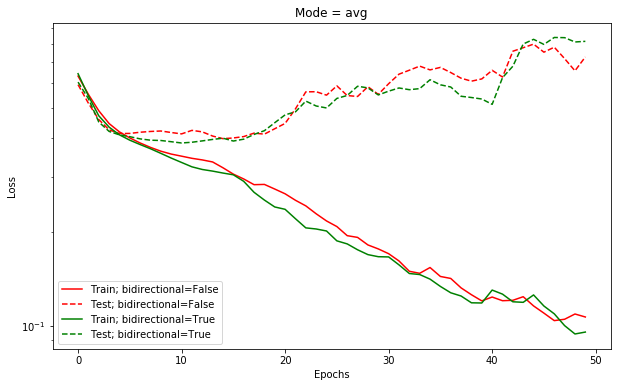

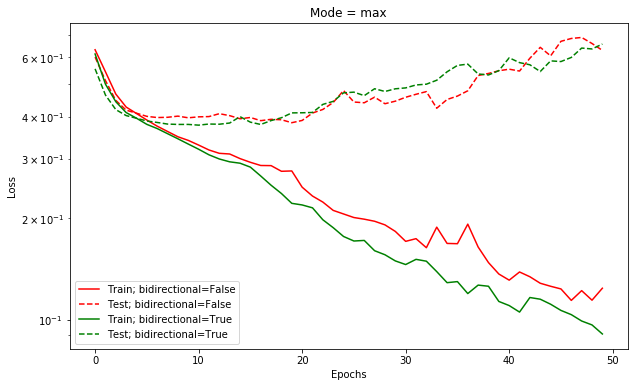

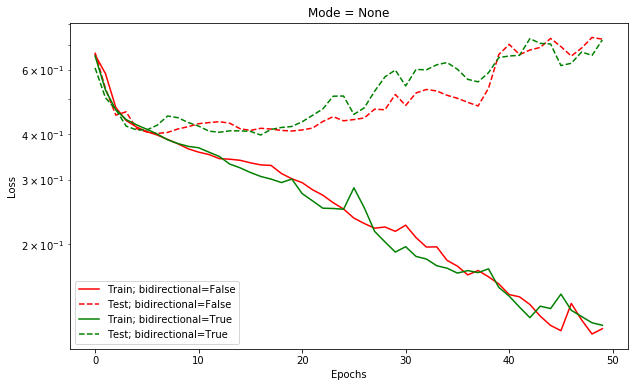

In [19]:
c = ['r', 'g', 'b']
for mode in ['avg', 'max', None]:
    i = 0

    plt.figure(figsize=(10, 6))
    plt.title('Mode = {}'.format(mode))
    for bidir in [False, True]:
        model = models[(mode, bidir)]
        plt.semilogy(model['train_err'], c=c[i], label='Train; bidirectional={}'.format(bidir))
        plt.semilogy(model['test_err'], '--', c=c[i], label='Test; bidirectional={}'.format(bidir))

        i += 1
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

Из графиков видно, что для взятия способа взятия последнего элемента и среднего сильно переобучаются, тогда как взятие максимума стабильнее.

Нарисуем графики accuracy для моделей

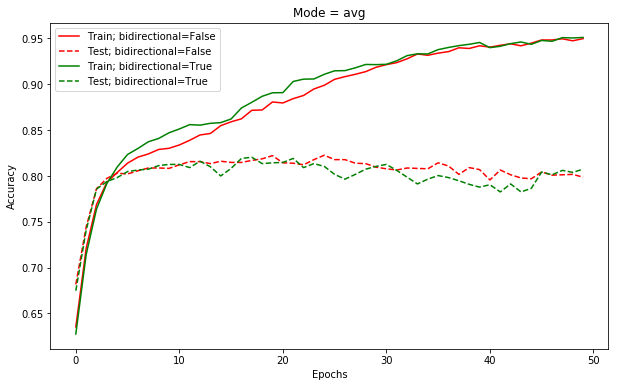

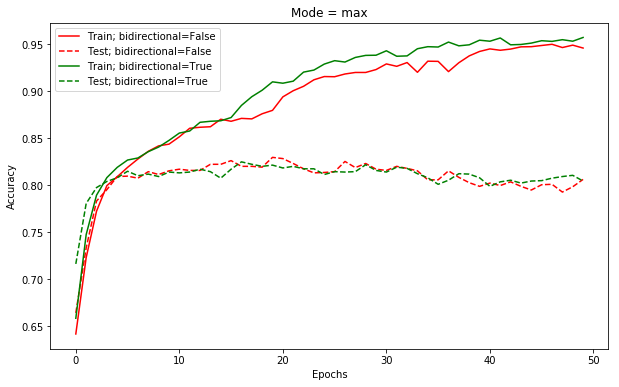

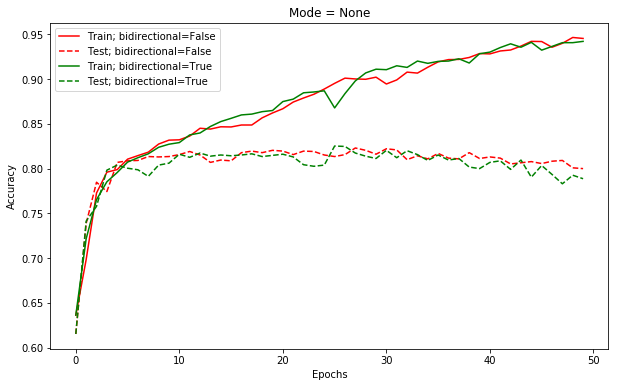

In [20]:
c = ['r', 'g', 'b']
for mode in ['avg', 'max', None]:
    i = 0

    plt.figure(figsize=(10, 6))
    plt.title('Mode = {}'.format(mode))
    for bidir in [False, True]:
        model = models[(mode, bidir)]
        plt.plot(model['train_acc'], c=c[i], label='Train; bidirectional={}'.format(bidir))
        plt.plot(model['test_acc'], '--', c=c[i], label='Test; bidirectional={}'.format(bidir))

        i += 1
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

Сравним для двунаправленной сети данные способы по accuracy

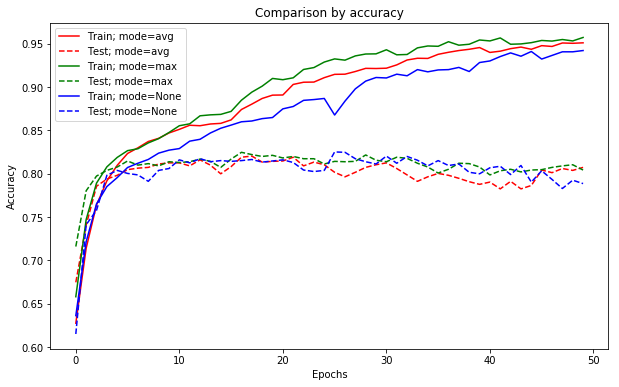

In [21]:
plt.figure(figsize=(10, 6))
plt.title('Comparison by accuracy')

i = 0
for mode in ['avg', 'max', None]:
    model = models[(mode, True)]
    plt.plot(model['train_acc'], c=c[i], label='Train; mode={}'.format(mode))
    plt.plot(model['test_acc'], '--', c=c[i], label='Test; mode={}'.format(mode))
    i += 1

plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Также по качеству метод взятия максимума лучше других методов и переобучение не сильное

##### Выводы

Взятие максимума - стабильный метод. Loss уменьшается плавно, более-менее устойчив к переобучению. Также двунаправленная сеть лучше показывает себя по качеству.

### Доп. пункт 5
Batchnorm и Layernorm. Запрограммируйте RNN c layer normalization из статьи [Lei Ba et al., 2016]. Поэкспериментируйте с применением обычной batch normalization и layer normalization, сравните результаты.

In [22]:
models5 = {}
models5['none'] = train(train_data, test_data, 40, 100)

Prepare data ...
Building network ...
The network has 58101 params
Training ...
Epoch 0 	 loss / accuracy test = 0.6657, 0.6152 	 train = 0.6603, 0.6224 	 time = 0.36s
Epoch 1 	 loss / accuracy test = 0.5534, 0.7330 	 train = 0.5816, 0.6873 	 time = 0.29s
Epoch 2 	 loss / accuracy test = 0.4806, 0.7635 	 train = 0.4838, 0.7642 	 time = 0.29s
Epoch 3 	 loss / accuracy test = 0.4244, 0.7957 	 train = 0.4389, 0.7916 	 time = 0.29s
Epoch 4 	 loss / accuracy test = 0.4122, 0.8052 	 train = 0.4213, 0.7998 	 time = 0.30s
Epoch 5 	 loss / accuracy test = 0.4118, 0.8087 	 train = 0.4062, 0.8140 	 time = 0.30s
Epoch 6 	 loss / accuracy test = 0.4095, 0.8083 	 train = 0.3907, 0.8251 	 time = 0.30s
Epoch 7 	 loss / accuracy test = 0.4180, 0.8100 	 train = 0.3810, 0.8285 	 time = 0.29s
Epoch 8 	 loss / accuracy test = 0.4230, 0.8122 	 train = 0.3714, 0.8349 	 time = 0.29s
Epoch 9 	 loss / accuracy test = 0.4241, 0.8065 	 train = 0.3635, 0.8365 	 time = 0.30s
Epoch 10 	 loss / accuracy test = 0.4270

In [23]:
class LayerNorm1d(nn.Module):
    def __init__(self, size, eps=1e-6):
        super(LayerNorm1d, self).__init__()
        self.eps = eps
        
        self.gain = nn.Parameter(torch.ones(size))
        self.bias = nn.Parameter(torch.zeros(size))
       
    def forward(self, z):
        mu = z.mean(-1, keepdim=True)
        sigma = z.std(-1, keepdim=True)

        return self.gain * (z - mu) / (sigma + self.eps) + self.bias

class Net(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, MAX_LEN] 
    и применяет к нему следующие преобразования:
    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое. Из этого слоя нам нужно только выход в последний момент времени.
    3. Полносвязный слой для бинарной классификации с sigmoid в качестве нелинейности.
    
    * Обратите внимание на параметр batch_first у рекуррентного слоя.
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, mode=None, bidirect=False):
        super(Net, self).__init__()
        hidden_layers = 1
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, hidden_layers, batch_first=True)
        
        self.decoder1 = nn.Linear(hidden_dim, 100)
        self.ln1 = LayerNorm1d(100)

        self.decoder2 = nn.Linear(100, 10)
        self.ln2 = LayerNorm1d(10)

        self.decoder = nn.Linear(10, 1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, names, lengths=None):
        encoded = self.encoder(names)
        output, hidden = self.rnn(encoded)

        output = output.max(1)[0]

        decoded = F.relu(self.ln1(self.decoder1(output)))
        decoded = F.relu(self.ln2(self.decoder2(decoded)))
        decoded = self.decoder(decoded)

        return self.sigmoid(decoded)

In [24]:
models5['ln'] = train(train_data, test_data, 40, 100)

Prepare data ...
Building network ...
The network has 69341 params
Training ...
Epoch 0 	 loss / accuracy test = 0.6335, 0.6152 	 train = 0.6515, 0.6362 	 time = 0.41s
Epoch 1 	 loss / accuracy test = 0.5730, 0.7139 	 train = 0.5899, 0.6553 	 time = 0.39s
Epoch 2 	 loss / accuracy test = 0.5203, 0.7700 	 train = 0.5157, 0.7731 	 time = 0.39s
Epoch 3 	 loss / accuracy test = 0.4611, 0.7952 	 train = 0.4736, 0.7947 	 time = 0.39s
Epoch 4 	 loss / accuracy test = 0.4363, 0.8017 	 train = 0.4335, 0.8149 	 time = 0.39s
Epoch 5 	 loss / accuracy test = 0.4351, 0.8100 	 train = 0.3979, 0.8324 	 time = 0.39s
Epoch 6 	 loss / accuracy test = 0.4376, 0.8074 	 train = 0.3695, 0.8513 	 time = 0.43s
Epoch 7 	 loss / accuracy test = 0.4261, 0.8157 	 train = 0.3410, 0.8629 	 time = 0.39s
Epoch 8 	 loss / accuracy test = 0.4412, 0.8109 	 train = 0.3180, 0.8760 	 time = 0.39s
Epoch 9 	 loss / accuracy test = 0.4683, 0.8026 	 train = 0.3047, 0.8800 	 time = 0.39s
Epoch 10 	 loss / accuracy test = 0.4767

In [25]:
class Net(nn.Module):
    """Класс задает простейшую рекуррентную сеть, которая принимает на вход батч размера [BATCH_SIZE, MAX_LEN] 
    и применяет к нему следующие преобразования:
    
    1. Embedding для перевода кодировки символов в нормальное представление: VOCAB_SIZE -> emb_size
    2. Рекуррентный слой c n_hidden элементов на скрытом слое. Из этого слоя нам нужно только выход в последний момент времени.
    3. Полносвязный слой для бинарной классификации с sigmoid в качестве нелинейности.
    
    * Обратите внимание на параметр batch_first у рекуррентного слоя.
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, mode=None, bidirect=False):
        super(Net, self).__init__()
        hidden_layers = 1
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, hidden_layers, batch_first=True)
        
        self.decoder1 = nn.Linear(hidden_dim, 100)
        self.bn1 = nn.BatchNorm1d(100)

        self.decoder2 = nn.Linear(100, 10)
        self.bn2 = nn.BatchNorm1d(10)

        self.decoder = nn.Linear(10, 1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, names, lengths=None):
        encoded = self.encoder(names)
        output, hidden = self.rnn(encoded)

        output = output.max(1)[0]

        decoded = F.relu(self.bn1(self.decoder1(output)))
        decoded = F.relu(self.bn2(self.decoder2(decoded)))
        decoded = self.decoder(decoded)

        return self.sigmoid(decoded)

In [26]:
models5['bn'] = train(train_data, test_data, 40, 100)

Prepare data ...
Building network ...
The network has 69341 params
Training ...
Epoch 0 	 loss / accuracy test = 0.5548, 0.7604 	 train = 0.6105, 0.6891 	 time = 0.36s
Epoch 1 	 loss / accuracy test = 0.4821, 0.7935 	 train = 0.5061, 0.7964 	 time = 0.34s
Epoch 2 	 loss / accuracy test = 0.4430, 0.8000 	 train = 0.4404, 0.8195 	 time = 0.34s
Epoch 3 	 loss / accuracy test = 0.4189, 0.8017 	 train = 0.3903, 0.8376 	 time = 0.35s
Epoch 4 	 loss / accuracy test = 0.4129, 0.7987 	 train = 0.3501, 0.8513 	 time = 0.35s
Epoch 5 	 loss / accuracy test = 0.4095, 0.8087 	 train = 0.3188, 0.8673 	 time = 0.41s
Epoch 6 	 loss / accuracy test = 0.4116, 0.8117 	 train = 0.2902, 0.8782 	 time = 0.41s
Epoch 7 	 loss / accuracy test = 0.4084, 0.8170 	 train = 0.2656, 0.8869 	 time = 0.40s
Epoch 8 	 loss / accuracy test = 0.4190, 0.8196 	 train = 0.2425, 0.8982 	 time = 0.41s
Epoch 9 	 loss / accuracy test = 0.4376, 0.8209 	 train = 0.2232, 0.9076 	 time = 0.35s
Epoch 10 	 loss / accuracy test = 0.4423

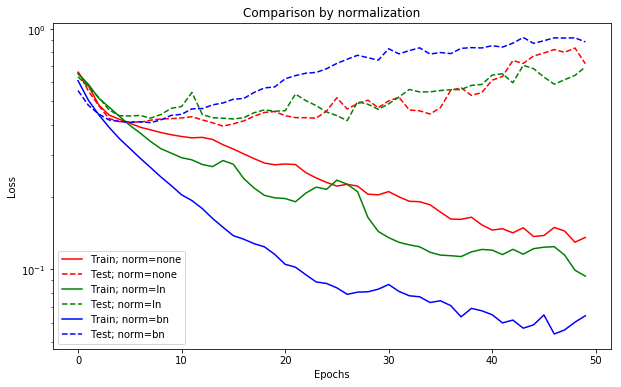

In [32]:
plt.figure(figsize=(10, 6))
plt.title('Comparison by normalization')

i = 0
for norm in ['none', 'ln', 'bn']:
    model = models5[norm]
    plt.semilogy(model['train_err'], c=c[i], label='Train; norm={}'.format(norm))
    plt.semilogy(model['test_err'], '--', c=c[i], label='Test; norm={}'.format(norm))
    i += 1

plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Из графика сходимости видно, что при batch нормализации большое переобучение, тогда как layer нормализация показывает относительно меньшее переобучение. Также скорость сходимости лучше для обоих нормализаций

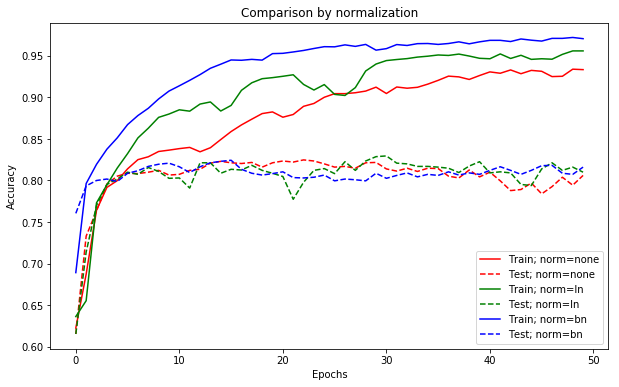

In [30]:
plt.figure(figsize=(10, 6))
plt.title('Comparison by normalization')

i = 0
for norm in ['none', 'ln', 'bn']:
    model = models5[norm]
    plt.plot(model['train_acc'], c=c[i], label='Train; norm={}'.format(norm))
    plt.plot(model['test_acc'], '--', c=c[i], label='Test; norm={}'.format(norm))
    i += 1

plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Из графика точности видно, что нормализация хорошо способствует обучению на обучающую выборку, но в целом на валидационной выборке все методы показывают одинаковые результаты.

##### Выводы

Нормализация слоев и батчей увеличивает сходимость, но в случае нормализации батчей увеличивается переобучение.

# С новым годом!